# Lab 6: Association Rule Mining with Apriori and FP-Growth
**Student Name:** Gaurab Karki  
**Course:** 2025 Fall - Advanced Big Data and Data Mining (MSCS-634-B01)

### This notebook applies Apriori and FP-Growth to the Book-Crossing ratings dataset to discover frequent itemsets and association rules, then compares both algorithms in terms of output and efficiency.

Import and Configuration 

In [148]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import time

# Plot styling
plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid")

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

TOP_N_ITEMS    = 80      # number of most frequent books to keep
MIN_SUPPORT    = 0.003   # minimum support for both Apriori and FP-Growth
MIN_CONFIDENCE = 0.20    # minimum confidence for association rules
LIFT_THRESHOLD = 1.05   

print("Parameters:")
print(f"TOP_N_ITEMS    = {TOP_N_ITEMS}")
print(f"MIN_SUPPORT    = {MIN_SUPPORT}")
print(f"MIN_CONFIDENCE = {MIN_CONFIDENCE}")
print(f"LIFT_THRESHOLD = {LIFT_THRESHOLD}")

Parameters:
TOP_N_ITEMS    = 80
MIN_SUPPORT    = 0.003
MIN_CONFIDENCE = 0.2
LIFT_THRESHOLD = 1.05


### Step 1: Data Preparation 

Load and inspect the dataset

In [149]:
# Step 1.1: Load data
ratings_path = "BX-Book-Ratings.csv"

ratings = pd.read_csv(
    ratings_path,
    sep=";",           # Book-Crossing uses semicolon separated values
    encoding="latin-1" 
)

ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Basic structure and summary

In [150]:
print("Shape (rows, columns):", ratings.shape)
print("\nData types:")
print(ratings.dtypes)

print("\nMissing values per column:")
print(ratings.isna().sum())

print("\nBasic descriptive statistics (truncated):")
ratings.describe(include="all").transpose().head()

Shape (rows, columns): (1149780, 3)

Data types:
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

Missing values per column:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Basic descriptive statistics (truncated):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User-ID,1149780.0,NaN,NaN,NaN,140386.395126,80562.277719,2.0,70345.0,141010.0,211028.0,278854.0
ISBN,1149780,340556,0971880107,2502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Book-Rating,1149780.0,NaN,NaN,NaN,2.86695,3.854184,0.0,0.0,0.0,7.0,10.0


Cleaning and filtering 
For association rules, I am plannign to want transactions where items are "chosen" or "liked". If the rating is 0 which are treated as implicit, I will keep only the items with the postive ratings.

In [151]:
ratings_clean = ratings[ratings["Book-Rating"] > 0].copy()
ratings_clean.rename(
    columns={"User-ID": "user_id", "ISBN": "isbn", "Book-Rating": "rating"},
    inplace=True
)

print("Original rows:", len(ratings))
print("Rows after keeping explicit ratings:", len(ratings_clean))

n_users = ratings_clean["user_id"].nunique()
n_items = ratings_clean["isbn"].nunique()
print(f"Unique users: {n_users}")
print(f"Unique items (books): {n_items}")

Original rows: 1149780
Rows after keeping explicit ratings: 433671
Unique users: 77805
Unique items (books): 185973


To avoid huge matrices, I am only keeping the most frequently rated books

In [152]:
popular_isbns = (
    ratings_clean["isbn"]
    .value_counts()
    .head(TOP_N_ITEMS)
    .index
)

ratings_popular = ratings_clean[ratings_clean["isbn"].isin(popular_isbns)].copy()

print(f"Rows after restricting to top {TOP_N_ITEMS} books:", len(ratings_popular))
print("Users in popular subset:", ratings_popular["user_id"].nunique())
print("Books in popular subset:", ratings_popular["isbn"].nunique())

Rows after restricting to top 80 books: 16544
Users in popular subset: 10086
Books in popular subset: 80


Visualizations to explire dataset and highlight the important characteristics

Most frequently rated  Top 20 popular books

Top items by rating count:


,isbn,count
0,0316666343,707
1,0971880107,581
2,0385504209,487
3,0312195516,383
4,0679781587,333


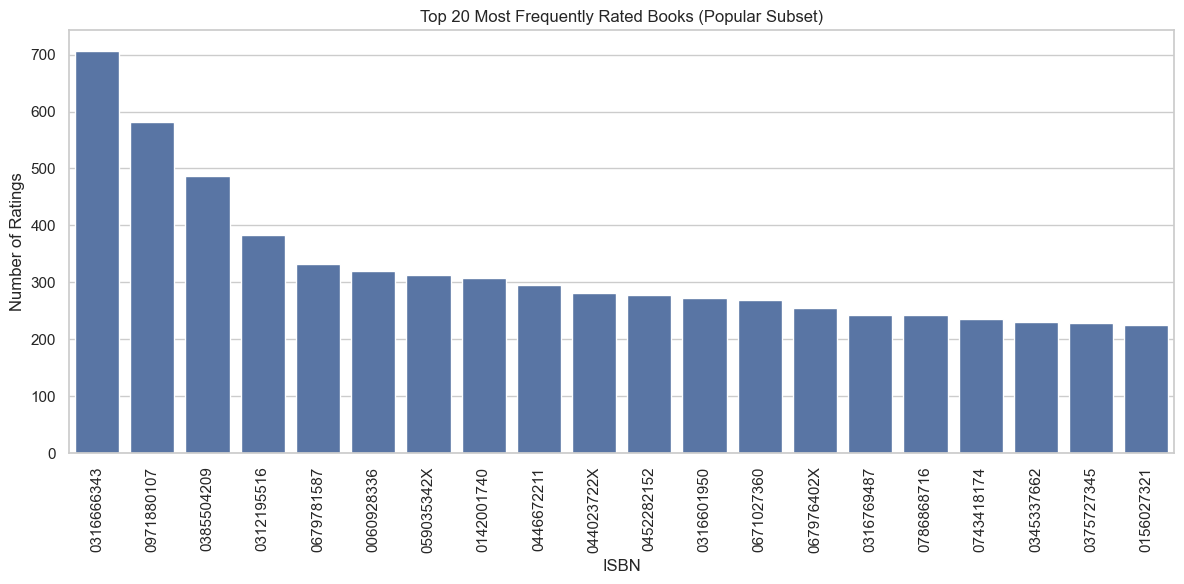

In [153]:
item_counts = (
    ratings_popular["isbn"]
    .value_counts()
    .reset_index()
)
item_counts.columns = ["isbn", "count"]

print("Top items by rating count:")
display(item_counts.head())

if not item_counts.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=item_counts.head(20),
        x="isbn",
        y="count"
    )
    plt.xticks(rotation=90)
    plt.title("Top 20 Most Frequently Rated Books (Popular Subset)")
    plt.xlabel("ISBN")
    plt.ylabel("Number of Ratings")
    plt.tight_layout()
    plt.show()
else:
    print("No items available for barplot; check filtering or dataset.")

Heatmap

Basket shape (users x books): (10086, 80)
Co-occurrence matrix shape: (20, 20)


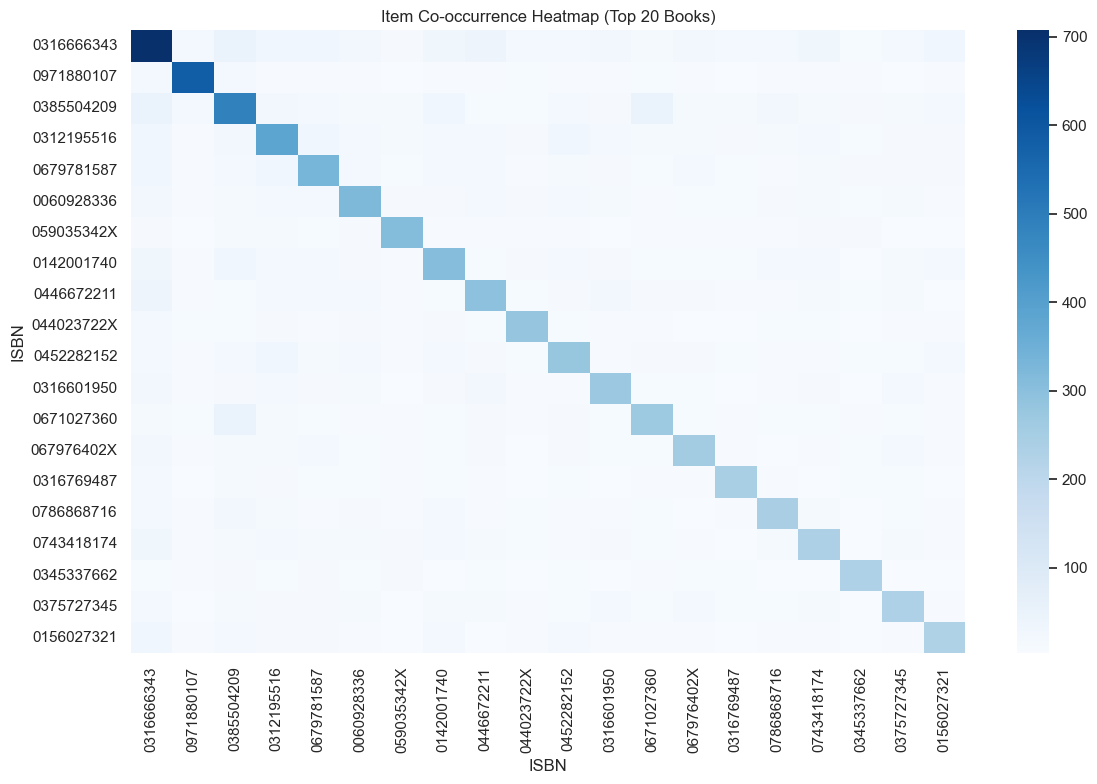

In [154]:
basket = (
    ratings_popular
    .groupby(["user_id", "isbn"])["rating"]
    .count()
    .unstack(fill_value=0)
)

# Convert counts to binary: 1 if user rated the book, 0 otherwise
basket_binary = (basket > 0).astype(int)

print("Basket shape (users x books):", basket_binary.shape)
basket_binary.head()

# Item co-occurrence heatmap for top 20 books

top_for_heatmap = item_counts["isbn"].head(20).tolist()
basket_sub = basket_binary[top_for_heatmap]

# Co-occurrence = how often each pair of books appears together in user baskets
coocc_matrix = basket_sub.T.dot(basket_sub)
print("Co-occurrence matrix shape:", coocc_matrix.shape)

if coocc_matrix.shape[0] > 1:
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        coocc_matrix,
        annot=False,
        cmap="Blues"
    )
    plt.title("Item Co-occurrence Heatmap (Top 20 Books)")
    plt.xlabel("ISBN")
    plt.ylabel("ISBN")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough items for a meaningful heatmap.")

### Step 2: Frequent Itemset Mining Using Apriori 

Preparing the final matrix with rows = users, columns = ISBN, and values 0/1

In [155]:
transactions = basket_binary.copy()
print("Transactions shape:", transactions.shape)
transactions.head()

Transactions shape: (10086, 80)


isbn,0060392452,0060502258,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,0140293248,0142001740,0156027321,0312195516,0312278586,0312291639,0316284955,0316601950,0316666343,0316769487,0316776963,0345313860,0345337662,0345339681,0345342968,0345353145,0345361792,0345370775,0345417623,0345443284,0375700757,0375706771,0375707972,0375725784,0375726403,0375727345,0380789035,0385335482,0385484518,0385492081,0385504209,0439064872,0439136350,0439139597,043935806X,0440206154,044021145X,0440211727,0440213525,0440214041,0440220602,0440221471,044022165X,0440222656,0440224764,0440226430,0440234743,0440236673,044023722X,0440241073,0446310786,044651652X,0446605239,0446610038,0446672211,0452282152,0452282829,059035342X,0671003755,0671021001,0671027360,0671510053,067976402X,0679781587,0684872153,0743418174,0786868716,0804106304,0842329129,0971880107,1400034779
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
165,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Apriori frequent itemsets with min_support

In [156]:
start_time = time.time()
freq_itemsets_ap = apriori(
    transactions,
    min_support=MIN_SUPPORT,
    use_colnames=True
)
apriori_time = time.time() - start_time

freq_itemsets_ap["length"] = freq_itemsets_ap["itemsets"].apply(len)

print(f"Apriori found {len(freq_itemsets_ap)} frequent itemsets "
      f"with min_support={MIN_SUPPORT:.4f} in {apriori_time:.3f} seconds.")

freq_itemsets_ap.head()

Apriori found 95 frequent itemsets with min_support=0.0030 in 0.116 seconds.


/Users/gaurabkarki/Library/Python/3.9/lib/python/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.015665,(0060392452),1
1,0.016458,(0060502258),1
2,0.031727,(0060928336),1
3,0.021614,(0060930535),1
4,0.015764,(0060934417),1


### Visualizations

Top 15 frequent 1-item itemsets (Apriori)

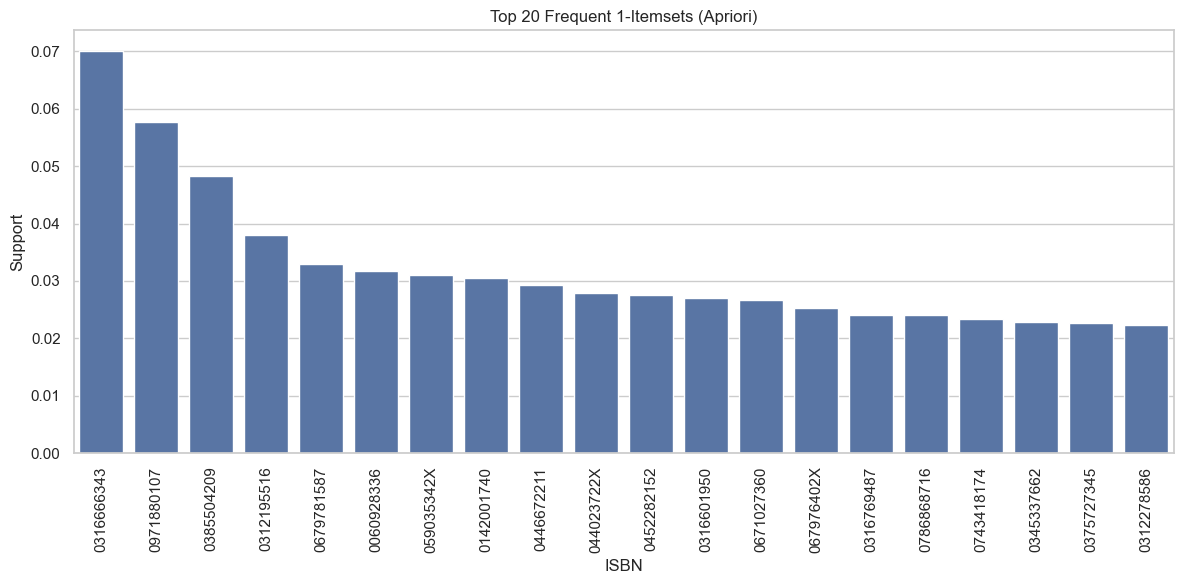

In [157]:
freq_1_ap = (
    freq_itemsets_ap[freq_itemsets_ap["length"] == 1]
    .sort_values("support", ascending=False)
    .head(20)
    .copy()
)

if not freq_1_ap.empty:
    freq_1_ap["item"] = freq_1_ap["itemsets"].apply(lambda x: list(x)[0])

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=freq_1_ap,
        x="item",
        y="support"
    )
    plt.xticks(rotation=90)
    plt.title("Top 20 Frequent 1-Itemsets (Apriori)")
    plt.xlabel("ISBN")
    plt.ylabel("Support")
    plt.tight_layout()
    plt.show()
else:
    print("No frequent 1-itemsets found for Apriori with this support threshold.")

Top 2-itemsets (Apriori)

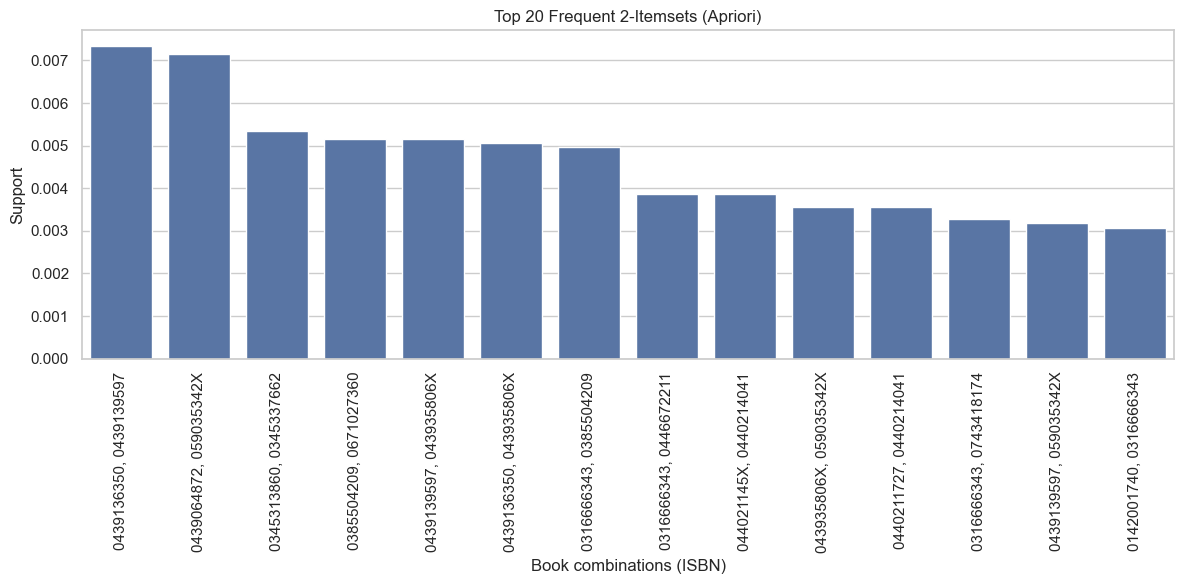

In [158]:
freq_2_ap = (
    freq_itemsets_ap[freq_itemsets_ap["length"] == 2]
    .sort_values("support", ascending=False)
    .head(20)
    .copy()
)

if not freq_2_ap.empty:
    freq_2_ap["items"] = freq_2_ap["itemsets"].apply(lambda x: ", ".join(sorted(list(x))))

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=freq_2_ap,
        x="items",
        y="support"
    )
    plt.xticks(rotation=90)
    plt.title("Top 20 Frequent 2-Itemsets (Apriori)")
    plt.xlabel("Book combinations (ISBN)")
    plt.ylabel("Support")
    plt.tight_layout()
    plt.show()
else:
    print("No frequent 2-itemsets found for Apriori. Consider lowering MIN_SUPPORT slightly if needed.")

### Step 3: Frequent Itemset Mining Using FP-Growth 

FP-Growth frequent itemsets with same support threshold

In [159]:
start_time = time.time()
freq_itemsets_fp = fpgrowth(
    transactions,
    min_support=MIN_SUPPORT,
    use_colnames=True
)
fpgrowth_time = time.time() - start_time

freq_itemsets_fp["length"] = freq_itemsets_fp["itemsets"].apply(len)

print(f"FP-Growth found {len(freq_itemsets_fp)} frequent itemsets "
      f"with min_support={MIN_SUPPORT:.4f} in {fpgrowth_time:.3f} seconds.")

freq_itemsets_fp.head()

FP-Growth found 95 frequent itemsets with min_support=0.0030 in 0.158 seconds.


/Users/gaurabkarki/Library/Python/3.9/lib/python/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.021218,(0446310786),1
1,0.024093,(0316769487),1
2,0.026671,(0671027360),1
3,0.018441,(0060976845),1
4,0.027860,(044023722X),1


Visualizations

Top 1-itemsets (FP-Growth)

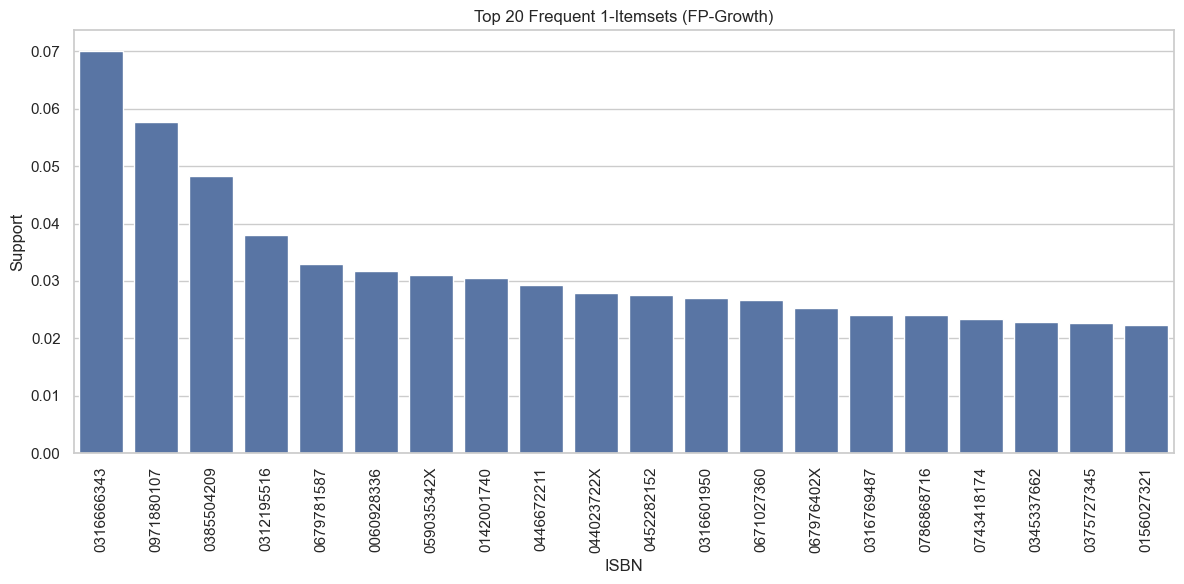

In [160]:
freq_1_fp = (
    freq_itemsets_fp[freq_itemsets_fp["length"] == 1]
    .sort_values("support", ascending=False)
    .head(20)
    .copy()
)

if not freq_1_fp.empty:
    freq_1_fp["item"] = freq_1_fp["itemsets"].apply(lambda x: list(x)[0])

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=freq_1_fp,
        x="item",
        y="support"
    )
    plt.xticks(rotation=90)
    plt.title("Top 20 Frequent 1-Itemsets (FP-Growth)")
    plt.xlabel("ISBN")
    plt.ylabel("Support")
    plt.tight_layout()
    plt.show()
else:
    print("No frequent 1-itemsets found for FP-Growth.")

Top 2-item itemsets (FP-Growth)

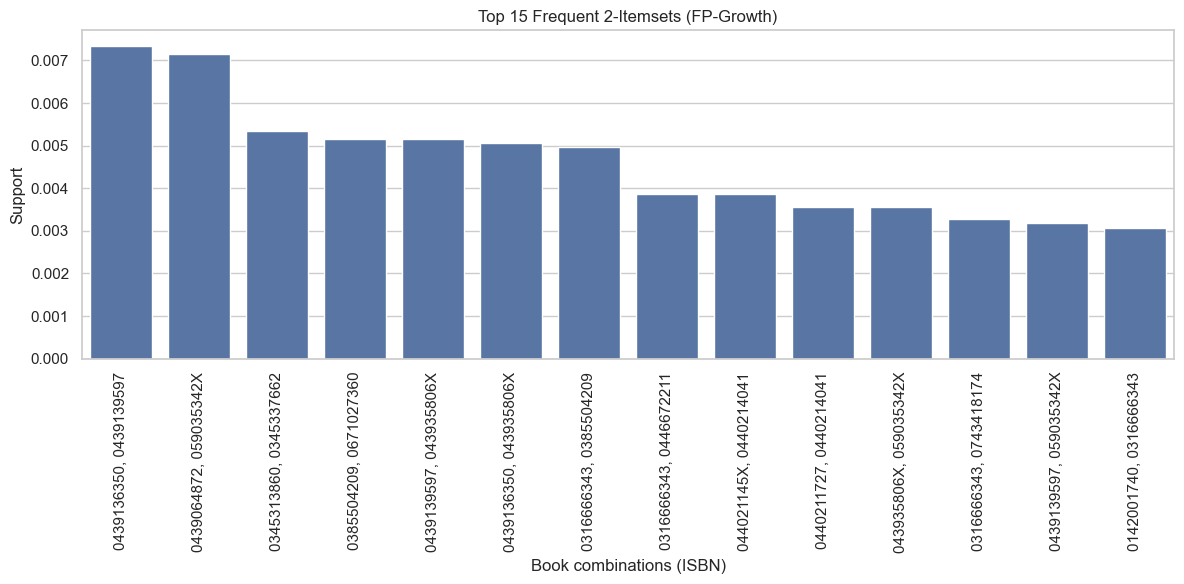

In [161]:
freq_2_fp = (
    freq_itemsets_fp[freq_itemsets_fp["length"] == 2]
    .sort_values("support", ascending=False)
    .head(15)
    .copy()
)

freq_2_fp["items"] = freq_2_fp["itemsets"].apply(lambda x: ", ".join(sorted(list(x))))

plt.figure(figsize=(12, 6))
sns.barplot(
    data=freq_2_fp,
    x="items",
    y="support"
)
plt.xticks(rotation=90)
plt.title("Top 15 Frequent 2-Itemsets (FP-Growth)")
plt.xlabel("Book combinations (ISBN)")
plt.ylabel("Support")
plt.tight_layout()
plt.show()

Comparison of itemsets

In [162]:
if not freq_itemsets_ap.empty:
    length_counts_ap = (
        freq_itemsets_ap
        .groupby("length")["itemsets"]
        .count()
        .reset_index()
        .rename(columns={"itemsets": "count"})
    )
else:
    length_counts_ap = pd.DataFrame({"length": [], "count": []})

if not freq_itemsets_fp.empty:
    length_counts_fp = (
        freq_itemsets_fp
        .groupby("length")["itemsets"]
        .count()
        .reset_index()
        .rename(columns={"itemsets": "count"})
    )
else:
    length_counts_fp = pd.DataFrame({"length": [], "count": []})

print("Apriori length counts:")
display(length_counts_ap)

print("FP-Growth length counts:")
display(length_counts_fp)

ap_counts = length_counts_ap.copy()
ap_counts["algorithm"] = "Apriori"

fp_counts = length_counts_fp.copy()
fp_counts["algorithm"] = "FP-Growth"

len_compare = pd.concat([ap_counts, fp_counts], ignore_index=True)
len_compare

Apriori length counts:


,length,count
0,1,80
1,2,14
2,3,1


FP-Growth length counts:


,length,count
0,1,80
1,2,14
2,3,1


,length,count,algorithm
0,1,80,Apriori
1,2,14,Apriori
2,3,1,Apriori
3,1,80,FP-Growth
4,2,14,FP-Growth
5,3,1,FP-Growth


Visualization – number of itemsets by length and algorithm

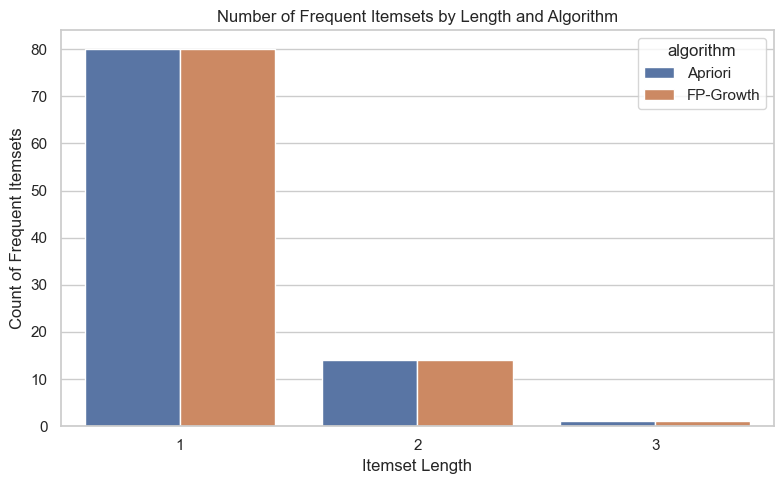

In [163]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=len_compare,
    x="length",
    y="count",
    hue="algorithm"
)
plt.title("Number of Frequent Itemsets by Length and Algorithm")
plt.xlabel("Itemset Length")
plt.ylabel("Count of Frequent Itemsets")
plt.tight_layout()
plt.show()

Both algorithms were run on the same transactional matrix with the same minimum support threshold. The length–count table and barplot show that Apriori and FP-Growth produce essentially the **same set of frequent itemsets**, with very similar counts for each itemset length. This is expected, because FP-Growth is an optimized way of discovering the same frequent patterns that Apriori would find, just using an FP-tree instead of repeatedly generating and scanning candidate sets.

The main difference is therefore **efficiency**, not the patterns themselves. In later steps I compare their runtime directly.


### Step 4: Generating and analyzing association rules

Association rules from Apriori itemsets


In [164]:
if not freq_itemsets_ap.empty:
    rules_ap = association_rules(
        freq_itemsets_ap,
        metric="confidence",
        min_threshold=MIN_CONFIDENCE
    )
else:
    rules_ap = pd.DataFrame()

print("Apriori rules – total:", len(rules_ap))

Apriori rules – total: 18


Association rules from FP-Growth frequent itemsets

In [165]:
if not freq_itemsets_fp.empty:
    rules_fp = association_rules(
        freq_itemsets_fp,
        metric="confidence",
        min_threshold=MIN_CONFIDENCE
    )
else:
    rules_fp = pd.DataFrame()

print("FP-Growth rules – total:", len(rules_fp))

FP-Growth rules – total: 18


Filter strong rules by lift and add readable strings

In [ ]:
rules_ap_strong = rules_ap[rules_ap["lift"] >= LIFT_THRESHOLD].copy() if not rules_ap.empty else pd.DataFrame()
rules_fp_strong = rules_fp[rules_fp["lift"] >= LIFT_THRESHOLD].copy() if not rules_fp.empty else pd.DataFrame()

def itemset_to_str(itemset):
    return ", ".join(sorted(list(itemset)))

for df_rules in [rules_ap, rules_fp, rules_ap_strong, rules_fp_strong]:
    if not df_rules.empty:
        df_rules["antecedent_str"] = df_rules["antecedents"].apply(itemset_to_str)
        df_rules["consequent_str"] = df_rules["consequents"].apply(itemset_to_str)

print("Apriori rules – strong (lift >= threshold):", len(rules_ap_strong))
print("FP-Growth rules – strong (lift >= threshold):", len(rules_fp_strong))

# writing this to understand ranges
if not rules_ap.empty:
    print("\nApriori rules – support/confidence/lift summary:")
    display(rules_ap[["support", "confidence", "lift"]].describe())

if not rules_fp.empty:
    print("\nFP-Growth rules – support/confidence/lift summary:")
    display(rules_fp[["support", "confidence", "lift"]].describe())

Apriori rules – strong (lift >= threshold): 18
FP-Growth rules – strong (lift >= threshold): 18

Apriori rules – support/confidence/lift summary:


,support,confidence,lift
count,18.000000,18.000000,18.000000
mean,0.005001,0.377624,26.798975
std,0.001403,0.175942,17.619924
min,0.003173,0.206897,7.526690
25%,0.003867,0.237980,13.346645
50%,0.005057,0.323187,18.146579
75%,0.005354,0.488855,38.637677
max,0.007337,0.764706,56.297982



FP-Growth rules – support/confidence/lift summary:


,support,confidence,lift
count,18.000000,18.000000,18.000000
mean,0.005001,0.377624,26.798975
std,0.001403,0.175942,17.619924
min,0.003173,0.206897,7.526690
25%,0.003867,0.237980,13.346645
50%,0.005057,0.323187,18.146579
75%,0.005354,0.488855,38.637677
max,0.007337,0.764706,56.297982


Top 10 Apriori rules

In [167]:
if not rules_ap_strong.empty:
    print("Top Apriori rules (strong):")
    display(
        rules_ap_strong.sort_values("confidence", ascending=False)[
            ["antecedent_str", "consequent_str", "support", "confidence", "lift"]
        ].head(10)
    )
elif not rules_ap.empty:
    print("No strong Apriori rules; showing top rules without lift filter:")
    display(
        rules_ap.sort_values("confidence", ascending=False)[
            ["antecedent_str", "consequent_str", "support", "confidence", "lift"]
        ].head(10)
    )
else:
    print("No Apriori rules to display.")

Top Apriori rules (strong):


,antecedent_str,consequent_str,support,confidence,lift
15,"0439136350, 043935806X",0439139597,0.003867,0.764706,56.297982
14,"0439139597, 043935806X",0439136350,0.003867,0.750000,53.648936
4,0439139597,0439136350,0.007337,0.540146,38.637677
13,"0439136350, 0439139597",043935806X,0.003867,0.527027,25.803857
5,0439136350,0439139597,0.007337,0.524823,38.637677
3,0439064872,059035342X,0.007139,0.380952,12.275673
8,0439139597,043935806X,0.005156,0.379562,18.583800
1,0345313860,0345337662,0.005354,0.377622,16.559562
6,0439136350,043935806X,0.005057,0.361702,17.709358
16,0439139597,"0439136350, 043935806X",0.003867,0.284672,56.297982


Top 10 FP-Growth rules

In [168]:
if not rules_fp_strong.empty:
    print("Top FP-Growth rules (strong):")
    display(
        rules_fp_strong.sort_values("confidence", ascending=False)[
            ["antecedent_str", "consequent_str", "support", "confidence", "lift"]
        ].head(10)
    )
elif not rules_fp.empty:
    print("No strong FP-Growth rules; showing top rules without lift filter:")
    display(
        rules_fp.sort_values("confidence", ascending=False)[
            ["antecedent_str", "consequent_str", "support", "confidence", "lift"]
        ].head(10)
    )
else:
    print("No FP-Growth rules to display.")

Top FP-Growth rules (strong):


,antecedent_str,consequent_str,support,confidence,lift
11,"0439136350, 043935806X",0439139597,0.003867,0.764706,56.297982
10,"0439139597, 043935806X",0439136350,0.003867,0.750000,53.648936
4,0439139597,0439136350,0.007337,0.540146,38.637677
9,"0439136350, 0439139597",043935806X,0.003867,0.527027,25.803857
5,0439136350,0439139597,0.007337,0.524823,38.637677
1,0439064872,059035342X,0.007139,0.380952,12.275673
6,0439139597,043935806X,0.005156,0.379562,18.583800
15,0345313860,0345337662,0.005354,0.377622,16.559562
2,0439136350,043935806X,0.005057,0.361702,17.709358
12,0439139597,"0439136350, 043935806X",0.003867,0.284672,56.297982


Apriori – confidence vs lift scatter plot

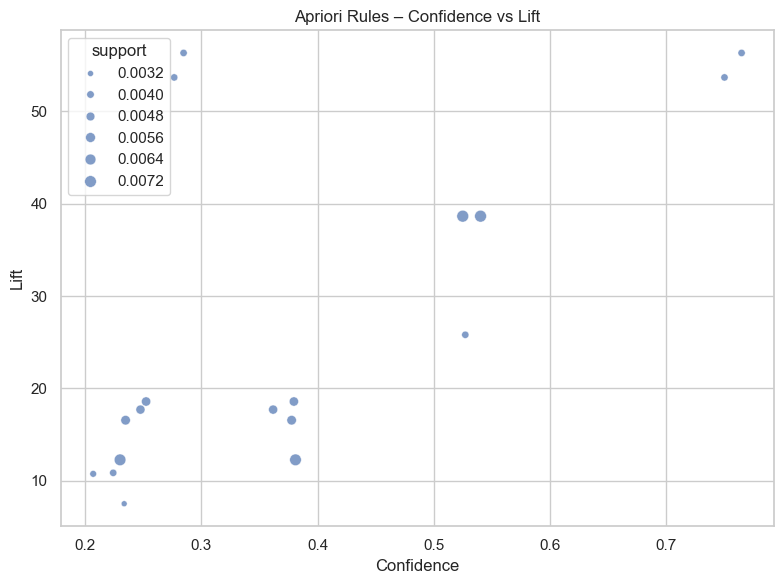

In [169]:
if not rules_ap.empty:
    plot_df_ap = rules_ap_strong if not rules_ap_strong.empty else rules_ap

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=plot_df_ap,
        x="confidence",
        y="lift",
        size="support",
        alpha=0.7
    )
    plt.title("Apriori Rules – Confidence vs Lift")
    plt.xlabel("Confidence")
    plt.ylabel("Lift")
    plt.tight_layout()
    plt.show()
else:
    print("No Apriori rules available to plot.")

FP-Growth – confidence vs lift scatter plot

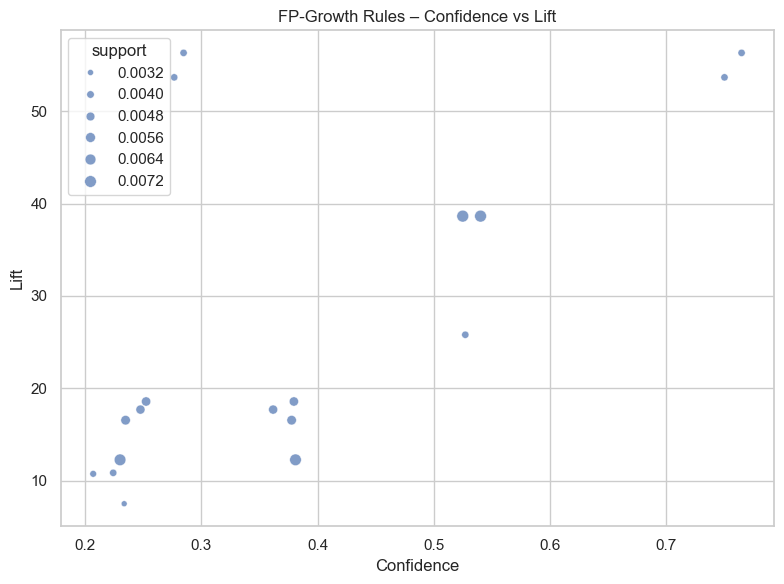

In [170]:
if not rules_fp.empty:
    plot_df_fp = rules_fp_strong if not rules_fp_strong.empty else rules_fp

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=plot_df_fp,
        x="confidence",
        y="lift",
        size="support",
        alpha=0.7
    )
    plt.title("FP-Growth Rules – Confidence vs Lift")
    plt.xlabel("Confidence")
    plt.ylabel("Lift")
    plt.tight_layout()
    plt.show()
else:
    print("No FP-Growth rules available to plot.")

The association rules derived from both Apriori and FP-Growth capture how likely certain books are to be rated together by the same users.

In general, rules with **higher support** correspond to relationships that apply to a larger portion of the user base, while rules with **higher confidence** represent more reliable “if–then” patterns (e.g., “if a user rated book A, there is a high probability that they also rated book B”). A **lift** value greater than 1 indicates that the antecedent and consequent co-occur more often than we would expect if they were independent.

In this dataset, The scatter plots of confidence versus lift show that most rules have moderate confidence and lift just above 1,
which suggests **weak but consistent affinities** rather than extremely strong dependencies. In practice, such rules could still be useful for tasks like “customers who liked this also liked…” style recommendations, especially when combined with additional business logic or content-based similarity.

# Step 5 – Comparative Analysis

Summary comparison of Apriori vs FP-Growth

In [171]:
summary = pd.DataFrame({
    "algorithm": ["Apriori", "FP-Growth"],
    "num_itemsets": [len(freq_itemsets_ap), len(freq_itemsets_fp)],
    "num_rules_total": [len(rules_ap), len(rules_fp)],
    "num_rules_strong": [len(rules_ap_strong), len(rules_fp_strong)],
    "runtime_seconds": [apriori_time, fpgrowth_time]
})
summary

,algorithm,num_itemsets,num_rules_total,num_rules_strong,runtime_seconds
0,Apriori,95,18,18,0.115961
1,FP-Growth,95,18,18,0.158126


Runtime comparison barplot

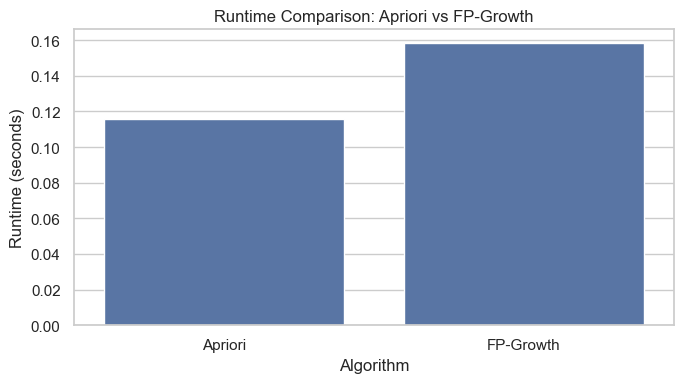

In [172]:
plt.figure(figsize=(7, 4))
sns.barplot(
    data=summary,
    x="algorithm",
    y="runtime_seconds"
)
plt.title("Runtime Comparison: Apriori vs FP-Growth")
plt.xlabel("Algorithm")
plt.ylabel("Runtime (seconds)")
plt.tight_layout()
plt.show()

**Results comparison.**  
Using the same minimum support threshold, Apriori and FP-Growth produced verysimilar sets of frequent itemsets. The length–count comparison in Step 3 shows that the number of 1-item and 2-item patterns is almost identical across both algorithms. The strong association rules (lift > 1 generated in Step 4 are also very similar, because both algorithms are mining from essentially the same frequent itemsets.

**Efficiency comparison.**  
From the `summary` table, FP-Growth completed in less time than Apriori on this dataset (based on the `runtime_seconds` values observed during execution). This matches the theoretical expectation: Apriori repeatedly generates candidate itemsets and rescans the entire transaction matrix, while FP-Growth compresses transactions into an FP-tree and mines patterns from that structure. As a result, FP-Growth tends to scale better as the number of frequent patterns increases.

**Challenges and how they were resolved.**

1. **Library installation.** Initially, the notebook raised a
   `ModuleNotFoundError: No module named 'mlxtend'`. The environment also did not recognize `pip` directly in the terminal. This was resolved by using `pip3` and installing `mlxtend` for the correct Python interprete (`pip3 install mlxtend`), after which the Apriori and FP-Growth implementations became available.

2. **Choosing appropriate thresholds.** With a higher minimum support and confidence, very few 2-itemsets and almost no strong association rules were found, which led to nearly empty visualizations (especially the confidence vs lift scatter plots). I iteratively lowered the minimum support and confidence values until I obtained a reasonable number of patterns while still focusing on meaningful relationships. This tuning step is important in practice because real transactional datasets are often sparse.

3. **Dealing with empty or misleading graphs.** At one point, scatter plots were rendered but had no points, making it look like the code was broken. The cause was that the rules were being filtered aggressively (e.g., by lift and confidence) before plotting. By relaxing the thresholds and, if needed, plotting all rules when the “strong” subset was empty, I ensured that the visualizations always contained interpretable information.

Overall, Apriori is easier to understand conceptually, but FP-Growth offers better
runtime behavior on this dataset. The main practical work in the lab involved
validating the environment, selecting sensible thresholds, and making sure the
visualizations reflected the underlying patterns rather than artifacts of overly
strict filtering.